In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
import random
import torchvision.transforms.functional as TF

In [2]:
from dataloader import DataExtractor
data_paths = DataExtractor.extract("data_zip", "data")

In [3]:
data_paths

{'Test': 'data\\Test', 'Training': 'data\\Training'}

In [4]:
paths = DataExtractor.get_internal_paths(data_paths['Training'])

In [5]:
paths

{'DepthImages': 'data\\Training\\DepthImages',
 'RGBImages': 'data\\Training\\RGBImages',
 'Train.csv': 'data\\Training\\Train.csv',
 'Training': 'data\\Training\\Training'}

In [6]:
class GrandDiscoveryDataset(torch.utils.data.Dataset):
    def __init__(self, csv_data, root_dir, RGBImage_path: str, DepthMap_path: str, is_train = False):
        if isinstance(csv_data, str):
            self.df = pd.read_csv(csv_data)
        else:
            self.df = csv_data.copy()
        if 'image_id' in self.df.columns:
            self.df = self.df.sort_values(by='image_id').reset_index(drop=True)
            
        self.root_dir = root_dir
        self.rgb_path = RGBImage_path
        self.depth_path = DepthMap_path
        # Variety Encoding
        self.label_encoder = LabelEncoder()
        self.df['Variety_Encoded'] = self.label_encoder.fit_transform(self.df['Variety'])
        self.is_train = is_train
        self.color_jitter = transforms.ColorJitter(
            brightness = 0.2,
            contrast = 0.2,
            saturation = 0.2
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(int(row['image_id'])) 
        rgb_path = os.path.join(self.rgb_path, f"RGB_{img_id}.png")
        depth_path = os.path.join(self.depth_path, f"Depth_{img_id}.png")

        rgb_raw = Image.open(rgb_path).convert('RGB')
        depth_raw = Image.open(depth_path) # 16-bit
        
        #0.7 multiplier for compute efficiency
        orig_w, orig_h = rgb_raw.size
        target_size = (int(orig_h * 0.5), int(orig_w * 0.5)) 
        #Used Functional transforms here to handle the dynamic 70% size efficiently
        rgb_img = transforms.functional.resize(rgb_raw, target_size)
        rgb_img = transforms.functional.to_tensor(rgb_img)
        rgb_img = transforms.functional.normalize(
            rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        #Depth Processing (Raw 16-bit for training)
        depth_array = np.array(depth_raw).astype(np.float32)
        depth_tensor = torch.from_numpy(depth_array).unsqueeze(0) 
        depth_tensor = transforms.functional.resize(depth_tensor, target_size)
        depth_tensor = depth_tensor / 65535.0

        if self.is_train:
            if random.random() > 0.5:
                rgb_img = TF.hflip(rgb_img)
                depth_tensor = TF.hflip(depth_tensor)

            if random.random() > 0.5:
                rgb_img = TF.vflip(rgb_img)
                depth_tensor = TF.vflip(depth_tensor)

            angles = [0, 90, 180, 270]
            angle = random.choice(angles)
            if angle > 0:
                rgb_img = TF.rotate(rgb_img, angle)
                depth_tensor = TF.rotate(depth_tensor, angle)

            rgb_img = self.color_jitter(rgb_img)

        #Tabular & Multi-Task Targets
        common_features = torch.tensor(row[['Height', 'Diameter']].values.astype('float32'))
        aux_targets = torch.tensor([
            row['LeafArea'],
            row['FreshWeightShoot'],
            row['Variety_Encoded']
        ], dtype=torch.float32)
        
        main_label = torch.tensor([row['DryWeightShoot']], dtype=torch.float32)

        return {
            'rgb': rgb_img,
            'depth': depth_tensor,
            'tab_in': common_features,
            'aux_targets': aux_targets,
            'label': main_label
        }

In [7]:
dataset = GrandDiscoveryDataset(paths['Train.csv'], data_paths['Training'], paths['RGBImages'], paths['DepthImages'])

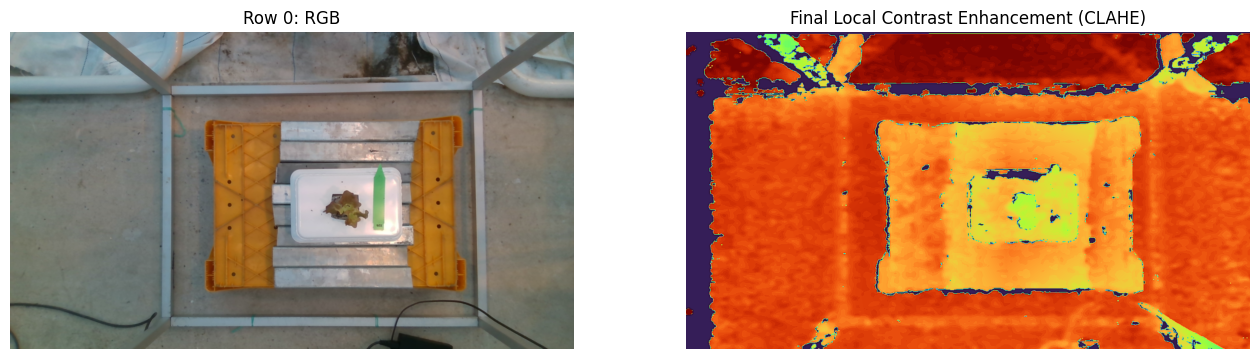

Features: [8.5, 8.199999809265137] | DryWeight: 0.1000


In [8]:
from dataloader import DataViewer

DataViewer.inspect_sample(dataset[1])

In [9]:
DataViewer.view_csv(paths['Train.csv'])

Dataset Shape: (231, 7)
------------------------------
Column Types:
image_id              int64
Height              float64
Diameter            float64
LeafArea            float64
FreshWeightShoot    float64
Variety                 str
DryWeightShoot      float64
dtype: object
------------------------------


,image_id,Height,Diameter,LeafArea,FreshWeightShoot,Variety,DryWeightShoot
0,1,8.2,12.0,80.6,2.6,Satine,0.14
1,2,8.5,8.2,67.4,2.1,Satine,0.10
2,3,7.5,9.5,65.0,2.0,Satine,0.09
3,6,8.4,13.4,107.8,3.3,Lugano,0.14
4,8,8.3,12.2,79.8,2.5,Lugano,0.10


In [10]:
len(dataset)

231

### Training Pipeline

In [11]:
import os
import pandas as pd

df = pd.read_csv(paths['Train.csv'])

valid_rows = []
missing_count = 0

for index, row in df.iterrows():
    img_id = str(int(row['image_id']))
    rgb_file = os.path.join(paths['RGBImages'], f"RGB_{img_id}.png")
    depth_file = os.path.join(paths['DepthImages'], f"Depth_{img_id}.png")
    
    if os.path.exists(rgb_file) and os.path.exists(depth_file):
        valid_rows.append(True)
    else:
        valid_rows.append(False)
        missing_count += 1
        print(f"Dropping image_id {img_id}: File missing from disk.")

df = df[valid_rows]
df = df.sort_values(by='image_id').reset_index(drop=True)

print("-" * 30)
print(f"Cleanup Complete! Dropped {missing_count} ghost images.")
print(f"Dataframe defined with {len(df)} safe rows.")
print(df.head())

Dropping image_id 332: File missing from disk.
------------------------------
Cleanup Complete! Dropped 1 ghost images.
Dataframe defined with 230 safe rows.
   image_id  Height  Diameter  LeafArea  FreshWeightShoot Variety  \
0         1     8.2      12.0      80.6               2.6  Satine   
1         2     8.5       8.2      67.4               2.1  Satine   
2         3     7.5       9.5      65.0               2.0  Satine   
3         6     8.4      13.4     107.8               3.3  Lugano   
4         8     8.3      12.2      79.8               2.5  Lugano   

   DryWeightShoot  
0            0.14  
1            0.10  
2            0.09  
3            0.14  
4            0.10  


In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = GrandDiscoveryDataset(train_df, data_paths['Training'], paths['RGBImages'], paths['DepthImages'], is_train=True)

val_dataset = GrandDiscoveryDataset(val_df, data_paths['Training'], paths['RGBImages'], paths['DepthImages'], is_train=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [13]:
data_batch = next(iter(train_loader))
print({data_batch['depth'].shape})

{torch.Size([8, 1, 540, 960])}


In [14]:
import torch
import torch.nn as nn
from torchvision import models

class SEBlock1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        weight = self.fc(x) 
        return x * weight

class main_model(nn.Module):
    def __init__(self, num_aux=3):
        super().__init__()
        # RGB Branch
        self.rgb_branch = models.resnet50(weights=None)
        self.rgb_branch.fc = nn.Identity()  
        self.rgb_se = SEBlock1D(2048) 
        
        # Depth Branch
        self.depth_branch = models.resnet50(weights=None)
        self.depth_branch.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.depth_branch.fc = nn.Identity()
        self.depth_se = SEBlock1D(2048)

        # Tabular Controller
        self.tab_branch = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        
        # Fusion & Heads
        self.fusion = nn.Sequential(
            nn.Linear(2048 + 2048 + 128, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.main_head = nn.Linear(512, 1)       
        self.aux_head = nn.Linear(512, num_aux)  
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)    


    def forward(self, rgb, depth, tab):
        x_rgb = self.rgb_branch(rgb)        
        x_rgb = self.rgb_se(x_rgb)          
        x_depth = self.depth_branch(depth)  
        x_depth = self.depth_se(x_depth)    
        x_tab = self.tab_branch(tab)        
        fused = torch.cat((x_rgb, x_depth, x_tab), dim=1) 
        fused_features = self.fusion(fused)
        main_out = self.main_head(fused_features)
        aux_out = self.aux_head(fused_features)
        
        return main_out, aux_out

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = main_model(num_aux=3).to(device)
print(f"Model loaded on: {device}")

criterion_main = nn.MSELoss() 
criterion_aux = nn.MSELoss()
criterion_mae = nn.L1Loss(reduction='sum')

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

num_epochs = 20
best_val_mae = float('inf') 

print("Starting Training (Explosion-Proof Mode)...")
print("-" * 40)

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    
    for batch in train_loader:
        rgb = batch['rgb'].to(device)
        depth = batch['depth'].to(device)
        tab = batch['tab_in'].to(device)
        label = batch['label'].to(device)
        aux = batch['aux_targets'].to(device)
        
        optimizer.zero_grad()
        
        main_out, aux_out = model(rgb, depth, tab)
        
        loss_main = criterion_main(main_out, label)
        loss_aux = criterion_aux(aux_out, aux) 
        loss = loss_main 

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item() * rgb.size(0)
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    

    model.eval()
    val_loss = 0.0
    val_mae_sum = 0.0 
    
    with torch.no_grad(): 
        for batch in val_loader:
            rgb = batch['rgb'].to(device)
            depth = batch['depth'].to(device)
            tab = batch['tab_in'].to(device)
            label = batch['label'].to(device)
            aux = batch['aux_targets'].to(device)
            
            main_out, aux_out = model(rgb, depth, tab)
            
            l_main = criterion_main(main_out, label)
            v_loss = l_main
            
            val_loss += v_loss.item() * rgb.size(0)
            
            # Calculate Absolute Error for Leaderboard tracking
            val_mae_sum += criterion_mae(main_out, label).item() 
            
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_mae = val_mae_sum / len(val_loader.dataset)
    
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch:02d}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MAE: {val_mae:.4f}")
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved! (MAE: {best_val_mae:.4f})")

print("-" * 40)
print(f"Training Complete! Best Validation MAE: {best_val_mae:.4f}")

Model loaded on: cuda
Starting Training (Explosion-Proof Mode)...
----------------------------------------
Epoch [01/20] | Train Loss: 16408.0906 | Val Loss: 158.6271 | Val MAE: 10.8102
New best model saved! (MAE: 10.8102)
Epoch [02/20] | Train Loss: 1044.3841 | Val Loss: 37848423.3043 | Val MAE: 5504.4519
Epoch [03/20] | Train Loss: 641.5439 | Val Loss: 5167609.0000 | Val MAE: 1983.2100
Epoch [04/20] | Train Loss: 183.7531 | Val Loss: 9926.2729 | Val MAE: 95.6495
Epoch [05/20] | Train Loss: 142.5347 | Val Loss: 10261.1292 | Val MAE: 96.1704
Epoch [06/20] | Train Loss: 20.4936 | Val Loss: 48979.0593 | Val MAE: 204.1833
Epoch [07/20] | Train Loss: 9.3476 | Val Loss: 107052.6230 | Val MAE: 289.1252
Epoch [08/20] | Train Loss: 7.2213 | Val Loss: 2478542.7174 | Val MAE: 1490.1233
Epoch [09/20] | Train Loss: 6.2663 | Val Loss: 1929999.5978 | Val MAE: 1236.4306
Epoch [10/20] | Train Loss: 5.6219 | Val Loss: 4383133.6087 | Val MAE: 1938.4612
Epoch [11/20] | Train Loss: 5.7599 | Val Loss: 2193

In [16]:
paths2 = DataExtractor.get_internal_paths(data_paths['Test'])

In [17]:
paths2

{'DepthImages': 'data\\Test\\DepthImages',
 'RGBImages': 'data\\Test\\RGBImages',
 'Test': 'data\\Test\\Test',
 'Test.csv': 'data\\Test\\Test.csv'}

In [21]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class GrandDiscoveryTestDataset(Dataset):
    def __init__(self, csv_file, rgb_path, depth_path):
        self.df = pd.read_csv(csv_file)
        self.rgb_path = rgb_path
        self.depth_path = depth_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(int(row['image_id']))
        
        rgb_file = os.path.join(self.rgb_path, f"RGB_{img_id}.png")
        depth_file = os.path.join(self.depth_path, f"Depth_{img_id}.png")
        
        rgb_raw = Image.open(rgb_file).convert('RGB')
        depth_raw = Image.open(depth_file)
        

        orig_w, orig_h = rgb_raw.size
        target_size = (int(orig_h * 0.5), int(orig_w * 0.5)) 
        
        rgb_img = transforms.functional.resize(rgb_raw, target_size)
        rgb_img = transforms.functional.to_tensor(rgb_img)
        rgb_img = transforms.functional.normalize(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        

        depth_array = np.array(depth_raw).astype(np.float32)
        depth_tensor = torch.from_numpy(depth_array).unsqueeze(0) 
        depth_tensor = transforms.functional.resize(depth_tensor, target_size)
        depth_tensor = depth_tensor / 65535.0 
        
        h = row['Height'] if 'Height' in self.df.columns else 8.2
        d = row['Diameter'] if 'Diameter' in self.df.columns else 11.0
        
        tab_in = torch.tensor([h, d], dtype=torch.float32)
        
        return {
            'image_id': int(img_id),
            'rgb': rgb_img,
            'depth': depth_tensor,
            'tab_in': tab_in
        }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = GrandDiscoveryTestDataset(paths2['Test.csv'], paths2['RGBImages'], paths2['DepthImages'])

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

model = main_model(num_aux=3).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval() 

print(f"Loaded best model weights! Starting inference on {len(test_dataset)} test plants...")

predictions = []
image_ids = []

with torch.no_grad(): 
    for batch in test_loader:
        rgb = batch['rgb'].to(device)
        depth = batch['depth'].to(device)
        tab = batch['tab_in'].to(device)
        ids = batch['image_id']
        
        main_out, aux_out = model(rgb, depth, tab)
        preds = main_out.cpu().numpy().flatten()
        
        predictions.extend(preds)
        image_ids.extend(ids.numpy())

submission_df = pd.DataFrame({
    'image_id': image_ids,
    'DryWeightShoot': predictions
})

submission_df = submission_df.sort_values('image_id').reset_index(drop=True)
submission_df.to_csv('final_model.csv', index=False)

print(" Inference Complete! 'final_model.csv' is saved.")

Loaded best model weights! Starting inference on 76 test plants...
 Inference Complete! 'final_model.csv' is saved.
